# HLCV Assignment 1
This notebook contains skeletons that you are supposed to fill in (watch out for <font color='red'>**TODO**</font> tags). In general, you are expected to implement methods yourself. For example, when asked to implement a method computing histograms you can use numpy array functions that help you implement this task, but not use the numpy implementation `np.histogram` for your solution. To submit your assignment, upload your completed notebook and a PDF report (use the provided Latex template with, for example, [Overleaf](http://overleaf.com)) that contains your observations.

In [1]:
import matplotlib.pyplot as plt, numpy as np, glob, os, scipy, itertools
# you do not need tqdm, but you might find it convenient
try:
    import tqdm.notebook as tqdm
except:
    class _tqdm:
        def tqdm(self, l):
            return l
    tqdm = _tqdm()

In this exercise you will first familiarise yourself with basic image filtering routines. The zip file contains image `graf.png`, which we will use for testing purposes.

# Part 1: Loading and Manipulating Images
We can load and show images using `matplotlib` for now.

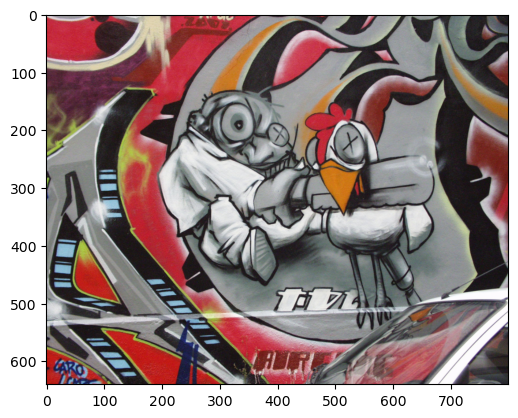

In [2]:
graf = plt.imread("graf.png")
plt.imshow(graf)

An image loaded with matplotlib is a matrix containing brightness values ∈ [0,1] for each color channel.

In [3]:
graf.shape, graf[0,0,0]

((640, 800, 3), 0.85882354)

Usually, images are saved in RGB (3 color channels) and uint8 (1 byte = 256 brightness values). In any case, the loaded brightness values are initially discrete.

In [4]:
graf[0,0,0], graf[0,0,0]*255

(0.85882354, 219.0000021457672)

219

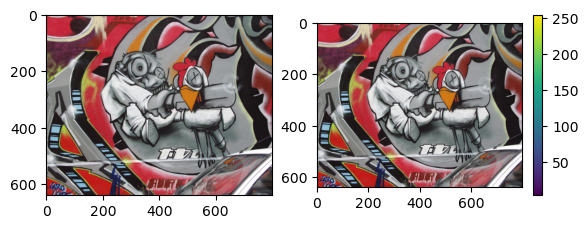

In [5]:
graf_uint8 = (graf*255).astype(np.uint8)

f, ax = plt.subplots(1,2)
ax[0].imshow(
    graf
)
i = ax[1].imshow(
    graf_uint8
)
plt.colorbar(i, fraction=0.04)
graf_uint8[0,0,0]

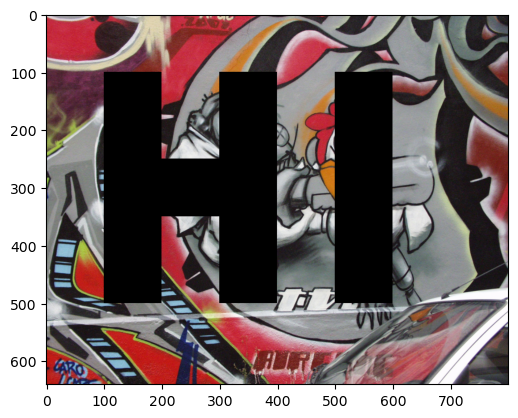

In [6]:
img = graf.copy()
img[100:500,100:200,:] = 0
img[250:350,200:300,:] = 0
img[100:500,300:400,:] = 0
img[100:500,500:600,:] = 0
plt.imshow(img)

<font color='red'>**TODO**</font>: Create 3 copies of the `graf` image where each only contains values in one color channel.

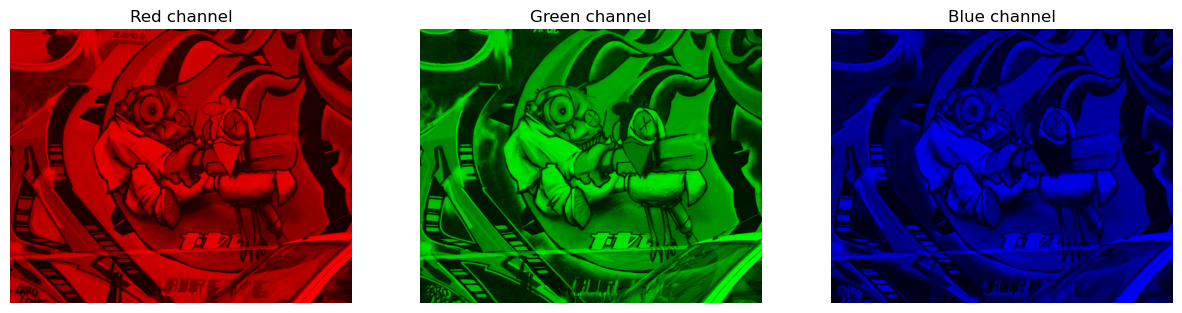

In [7]:
img = graf.copy()
# ... continue here
# Make three copies of the original image
red_img   = graf.copy()
green_img = graf.copy()
blue_img  = graf.copy()

# Zero out the other channels for each copy
red_img[:, :, 1] = 0   # remove G
red_img[:, :, 2] = 0   # remove B

green_img[:, :, 0] = 0 # remove R
green_img[:, :, 2] = 0 # remove B

blue_img[:, :, 0] = 0  # remove R
blue_img[:, :, 1] = 0  # remove G

# Plot all three side by side
f, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(red_img)
ax[0].set_title("Red channel")
ax[1].imshow(green_img)
ax[1].set_title("Green channel")
ax[2].imshow(blue_img)
ax[2].set_title("Blue channel")
for a in ax: a.axis("off")
plt.show()


<font color='red'>**TODO**</font>: Now lets turn the `graf` image into a gray value image by averaging over the color channels. Hint: `plt.imshow` has a default value for the argument `cmap` that you might want to change.

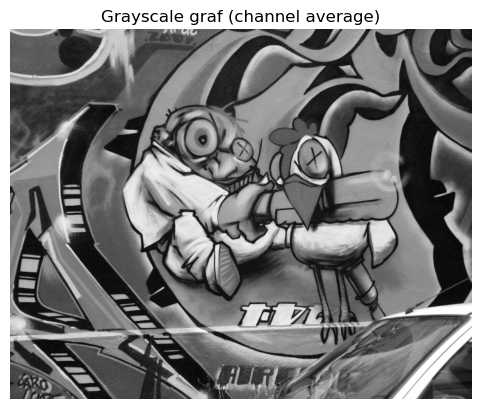

In [8]:
graf_gray = graf.copy()
# ... continue here
# Average over the last axis (the color channels R, G, B)
graf_gray = np.mean(graf, axis=2)

# Show it — use cmap="gray" so matplotlib renders it as grayscale
plt.imshow(graf_gray, cmap="gray")
plt.title("Grayscale graf (channel average)")
plt.axis("off")
plt.show()

# Part 2: Image Filtering
## a) Gaussian Filter
<font color='red'>**TODO**</font>: Lets start with a simple 1D Gaussian. Implement a method which computes the values of a 1D Gaussian for a given variance σ². The method should also give a vector of values on which the Gaussian filter is defined: integer values on the interval [-3σ, 3σ].

$$
G = \frac{1}{\sqrt{2 \pi \sigma}} \exp\left(-\frac{x^2}{2\sigma^2}\right)
$$

In [9]:
def gauss(sigma):
    x = np.arange(-int(3*sigma), int(3*sigma)+1)
    # ... continue here
    # y = ...
    y = (1.0 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-(x**2) / (2 * sigma**2))
    return x, y

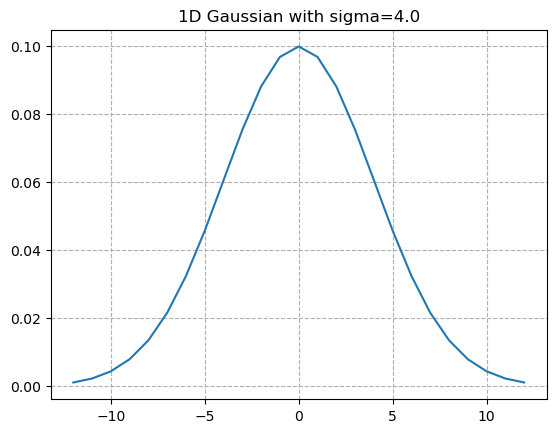

In [10]:
# plot your Gauss
sigma = 4.0
x, y = gauss(sigma)
plt.plot(x, y)
plt.title(f"1D Gaussian with sigma={sigma}")
plt.grid(linestyle="--")
plt.show()

<font color='red'>**TODO**</font>: Implement a 2D Gaussian filter. The function should take an image as an input and return the result of convolution of this image with 2D Gaussian kernel. First, lets start by implementing the 2D Gaussian kernel. Complete function `gausskernel` below.

In [11]:
def gausskernel(sigma):
    # ... continue here
    # coordinate grid in both x and y
    size = int(3 * sigma)
    x = np.arange(-size, size + 1)
    xx, yy = np.meshgrid(x, x)  # 2D grid

    # 2D Gaussian formula
    kernel = (1 / (2 * np.pi * sigma**2)) * np.exp(-(xx**2 + yy**2) / (2 * sigma**2))

    # normalize so sum(kernel) = 1
    kernel /= np.sum(kernel)
    return kernel

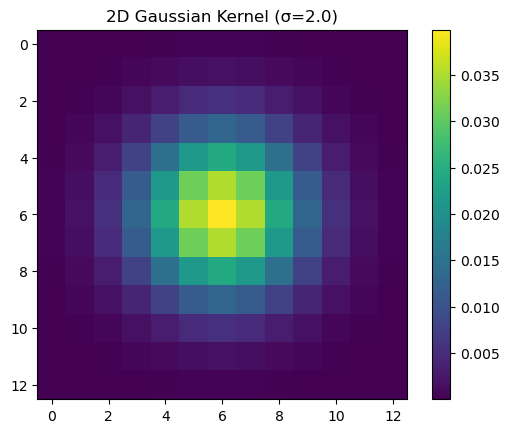

In [12]:
# plot your Gauss
kernel = gausskernel(2.0)
plt.imshow(kernel, cmap="viridis")
plt.title("2D Gaussian Kernel (σ=2.0)")
plt.colorbar()
plt.show()

<font color='red'>**TODO**</font>: Now implement a convolution operation by completing function `my_convolution`. Afterwards you can test function `gaussfilter` - it should blur our example images.

In [13]:
def my_padding(image, padding=0):
    if padding != 0:
        imagePadded = np.zeros((image.shape[0] + padding*2, image.shape[1] + padding*2))
        imagePadded[int(padding):int(-1 * padding), int(padding):int(-1 * padding)] = image
        return imagePadded
    
    return image

In [14]:
def my_convolution(image, kernel, padding=0, verbose=True):
    multiplications = 0
    
    kernel = np.flipud(np.fliplr(kernel))
    xKernShape = kernel.shape[0] 
    yKernShape = kernel.shape[1] 
    xImgShape = image.shape[0] 
    yImgShape = image.shape[1]
    xOutput = int((xImgShape - xKernShape + 2 * padding) + 1) 
    yOutput = int((yImgShape - yKernShape + 2 * padding) + 1)
    output = np.zeros((xOutput, yOutput))
    if verbose:
        print(output.shape)
    
    # Apply Equal Padding to All Sides
    imagePadded = my_padding(image, padding)
    
    # Iterate through image
    for y in range(yOutput):
        for x in range(xOutput):
            patch = imagePadded[x : x + xKernShape, y : y + yKernShape]
            output[x, y] = np.sum(patch * kernel)
            multiplications += xKernShape*yKernShape
    
    if verbose:
        print(f"Multiplications: {multiplications}")
    return output

def gaussfilter(image, sigma, padding=0):
    kernel = gausskernel(sigma)
    filtered = my_convolution(image, kernel, padding)
    return filtered

Here you can test your implementation. Start with `sigma=4.0` and play around with different sigma values.

(616, 776)
Multiplications: 298760000


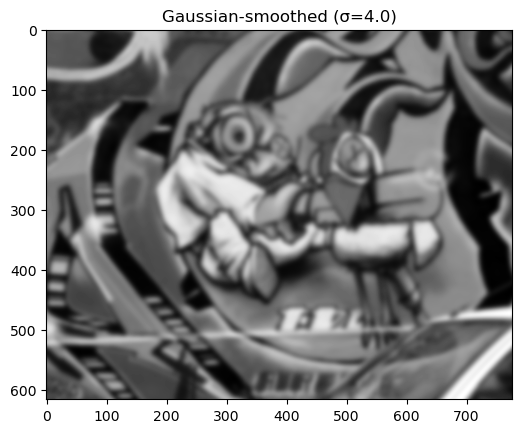

In [15]:
graf_smooth = gaussfilter(graf_gray, sigma=4.0)

plt.imshow(graf_smooth, cmap="gray")
plt.title(f"Gaussian-smoothed (σ={sigma})")
plt.show()

## b) Separability
The Gaussian filter is separable. This means we can first convolve each row of an image with a 1D filter and then convolve each column with another 1D filter instead of applying the corresponding 2D kernel (see lecture slides). Function `gaussfilter_sep` convolves a given image with two 1D Gaussians.

<font color='red'>**TODO**</font>: Test how much more efficient this method is compared to its 2D counterpart. What would you expect?

In [16]:
def gaussfilter_sep(image, sigma, padding=0):
    _, kernel = gauss(sigma)
    kernel = np.atleast_2d(kernel) / kernel.sum()
    filtered = my_convolution(image, kernel, padding)
    filtered = my_convolution(filtered, kernel.T, 0)
    return filtered

(640, 776)
Multiplications: 12416000
(616, 776)
Multiplications: 11950400


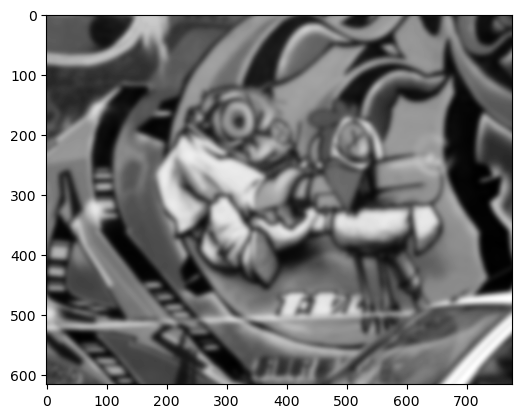

Diff. graf_smooth vs. graf_smooth_sep: 4.139948106551827e-11


In [17]:
graf_smooth_sep = gaussfilter_sep(graf_gray, sigma=4.0, padding=0)
plt.imshow(graf_smooth_sep, cmap="gray")
plt.show()

print(f"Diff. graf_smooth vs. graf_smooth_sep: {abs(graf_smooth-graf_smooth_sep).sum()}")

--- sigma = 1.0 ---
kernel size K = 7, expected speedup ~ 3.50x
2D best time: 0.8298 s, separable best time: 1.5264 s, speedup ≈ 0.54x
Sum abs diff: 3.068078e-11, max diff: 4.440892e-16

--- sigma = 2.0 ---
kernel size K = 13, expected speedup ~ 6.50x
2D best time: 0.8616 s, separable best time: 1.5471 s, speedup ≈ 0.56x
Sum abs diff: 2.576352e-11, max diff: 4.440892e-16

--- sigma = 4.0 ---
kernel size K = 25, expected speedup ~ 12.50x
2D best time: 1.0268 s, separable best time: 1.6222 s, speedup ≈ 0.63x
Sum abs diff: 4.380371e-11, max diff: 5.551115e-16

--- sigma = 8.0 ---
kernel size K = 49, expected speedup ~ 24.50x
2D best time: 1.5633 s, separable best time: 1.6888 s, speedup ≈ 0.93x
Sum abs diff: 2.005598e-11, max diff: 3.330669e-16



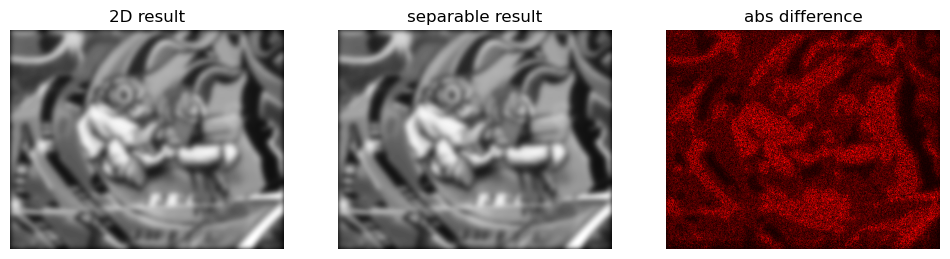

In [18]:
import time
import numpy as np
import matplotlib.pyplot as plt

# assume gausskernel, gauss, my_convolution, gaussfilter and gaussfilter_sep are defined

def time_run(func, *args, runs=3, verbose=False):
    times = []
    for _ in range(runs):
        t0 = time.perf_counter()
        out = func(*args)
        t1 = time.perf_counter()
        times.append(t1 - t0)
    if verbose:
        print(f"times: {times}")
    return np.min(times), out  # return best time and last output

# helper that wraps 2D gaussian filter using your functions
def gaussfilter_2d(image, sigma, padding=None):
    kernel = gausskernel(sigma)
    if padding is None:
        padding = kernel.shape[0] // 2
    return my_convolution(image, kernel, padding=padding, verbose=False)

# separable wrapper (useable with same padding semantic)
def gaussfilter_separable(image, sigma, padding=None):
    x, k1d = gauss(sigma)
    # normalize 1D kernel
    k1d = k1d / np.sum(k1d)
    k1d = np.atleast_2d(k1d)
    if padding is None:
        padding = k1d.shape[1] // 2
    # convolve rows then cols
    tmp = my_convolution(image, k1d, padding=padding, verbose=False)
    out = my_convolution(tmp, k1d.T, padding=0, verbose=False)
    return out

# Run timing tests for several sigma values
sigmas = [1.0, 2.0, 4.0, 8.0]   # pick interesting values, increase for larger kernels
results = []

for sigma in sigmas:
    print(f"--- sigma = {sigma} ---")
    kernel = gausskernel(sigma)
    K = kernel.shape[0]
    print(f"kernel size K = {K}, expected speedup ~ {K/2:.2f}x")
    pad = K // 2

    t2d, out2d = time_run(gaussfilter_2d, graf_gray, sigma, runs=3)
    tsep, outsep = time_run(gaussfilter_separable, graf_gray, sigma, runs=3)

    # error between outputs
    diff = np.abs(out2d - outsep)
    diff_sum = diff.sum()
    max_diff = diff.max()

    speedup = t2d / tsep if tsep > 0 else np.nan
    print(f"2D best time: {t2d:.4f} s, separable best time: {tsep:.4f} s, speedup ≈ {speedup:.2f}x")
    print(f"Sum abs diff: {diff_sum:.6e}, max diff: {max_diff:.6e}\n")

    results.append({
        "sigma": sigma,
        "K": K,
        "t2d": t2d,
        "tsep": tsep,
        "speedup": speedup,
        "diff_sum": diff_sum,
        "max_diff": max_diff
    })

# Optional: plot last pair to visually inspect
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(out2d, cmap="gray"); plt.title("2D result"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(outsep, cmap="gray"); plt.title("separable result"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(np.abs(out2d-outsep), cmap="hot"); plt.title("abs difference"); plt.axis("off")
plt.show()


## c) Derivative Filter
<font color='red'>**TODO**</font>: Implement a function `gaussdx` for creating a Gaussian derivative filter in 1D according to the following equation:

$$
\frac{d}{dx} G 
= \frac{d}{dx} \frac{1}{\sqrt{2 \pi \sigma}} \exp\left(-\frac{x^2}{2\sigma^2}\right) \\
= -\frac{1}{\sqrt{2 \pi \sigma^3}} x \exp\left(-\frac{x^2}{2\sigma^2}\right)
$$

In [19]:
def gaussdx(sigma):
    x = np.arange(-int(3*sigma), int(3*sigma)+1)
    y = - (1.0 / (np.sqrt(2.0 * np.pi) * (sigma**3))) * x * np.exp(-(x**2) / (2.0 * sigma**2)) # ... continue here
    return x, y


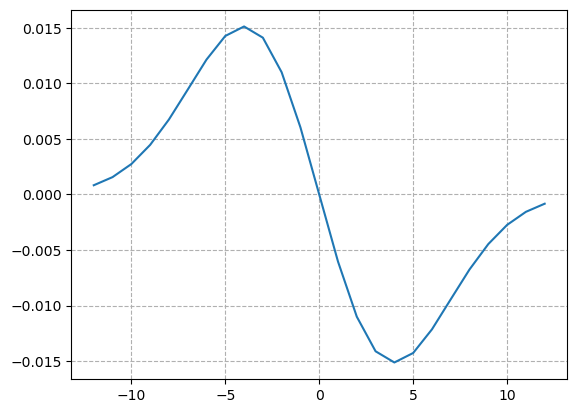

In [20]:
# plot your derivative filter
sigma = 4.0
x, y = gaussdx(sigma)
plt.plot(x, y)
plt.grid(linestyle="--")

The effect of applying a filter can be studied by observing its so-called impulse response. For this, we create a test image in which only the central pixel has a non-zero value:

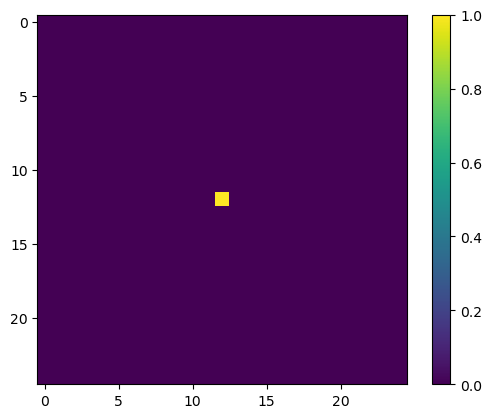

In [21]:
test_img = np.zeros((25,25))
test_img[12,12] = 1
plt.imshow(test_img)
plt.colorbar()

Now, given the following **1D** filter kernels:

In [22]:
_, G = gauss(1)
G = np.atleast_2d(G).T
_, D = gaussdx(1)
D = np.atleast_2d(D).T

<font color='red'>**TODO**</font>: What happens when you apply the following filter combinations? (G' is the transpose of G)
1. first G, then G'
2. first G, then D'
3. first D, then G'
4. first G', then D
5. first D', then G

First visualize each result on the test image. Then, answer the following question: What is the expected result when applying these filters to images?

In [23]:
# ... continue here
def apply_seq(img, k1, k2):
    pad1 = k1.shape[0] // 2
    pad2 = k2.shape[0] // 2
    # first convolution with padding to keep same size
    tmp = my_convolution(img, k1, padding=pad1, verbose=False)
    # second convolution, pad so output stays same
    out = my_convolution(tmp, k2, padding=pad2, verbose=False)
    return out

In [24]:
# sequences requested:
res = {}
res["1_G_then_Gt"] = apply_seq(test_img, G, G.T)
res["2_G_then_Dt"] = apply_seq(test_img, G, D.T)
res["3_D_then_Gt"] = apply_seq(test_img, D, G.T)
res["4_Gt_then_D"] = apply_seq(test_img, G.T, D)
res["5_Dt_then_G"] = apply_seq(test_img, D.T, G)

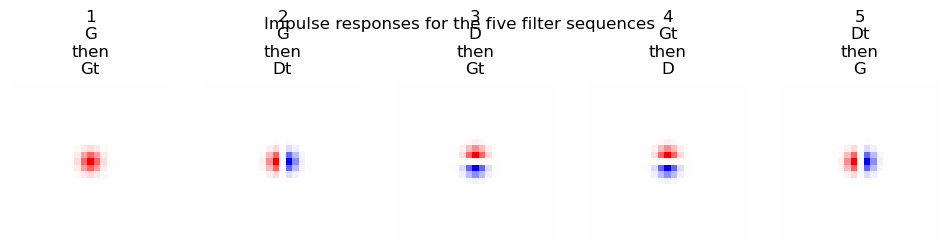

In [25]:
# plot results
keys = ["1_G_then_Gt", "2_G_then_Dt", "3_D_then_Gt", "4_Gt_then_D", "5_Dt_then_G"]
plt.figure(figsize=(12,3))
for i,k in enumerate(keys,1):
    plt.subplot(1,5,i)
    plt.imshow(res[k], cmap="bwr", vmin=-res[k].max(), vmax=res[k].max())
    plt.title(k.replace("_","\n"))
    plt.axis("off")
plt.suptitle("Impulse responses for the five filter sequences")
plt.show()

In [26]:
# show numerical summaries (optional)
for k in keys:
    print(k, "sum(abs)=", np.abs(res[k]).sum(), "max=", res[k].max(), "min=", res[k].min())

1_G_then_Gt sum(abs)= 0.999458791826337 max= 0.15915494309189535 min= 0.0
2_G_then_Dt sum(abs)= 0.7262997860596324 max= 0.09653235263005391 min= -0.09653235263005391
3_D_then_Gt sum(abs)= 0.7262997860596324 max= 0.09653235263005391 min= -0.09653235263005391
4_Gt_then_D sum(abs)= 0.7262997860596324 max= 0.09653235263005391 min= -0.09653235263005391
5_Dt_then_G sum(abs)= 0.7262997860596324 max= 0.09653235263005391 min= -0.09653235263005391


<font color='red'>**TODO**</font>: Use functions `gauss` and `gaussdx` in order to implement a function `gaussderiv` that returns the 2D Gaussian derivatives of an input image in x and y direction. Try the function on the given example images and comment on the output.

In [27]:
def gaussderiv(image, sigma, verbose=True):
    """
    Return a 2D derivative-of-Gaussian kernel and the image derivatives.
    The kernel is constructed so that:
      - kernel = G (vertical) outer D (horizontal)  -> ∂/∂x (dx)
      - kernel.T = D (vertical) outer G (horizontal) -> ∂/∂y (dy)

    To preserve the original image size we pad the image ourselves before
    calling `my_convolution(..., padding=0)` as required by your stub.
    """
    # ... continue here
    
    # 1D Gaussian and its derivative
    _, G = gauss(sigma)     # 1D Gaussian (row vector)
    _, D = gaussdx(sigma)   # 1D Gaussian derivative (row vector)

    # normalize smoothing kernel so it sums to 1
    G = G / np.sum(G)

    # build 2D kernels via outer product
    # kernel: vertical smoothing (G) times horizontal derivative (D)
    kernel = np.outer(G, D)

    # compute padding so final output keeps same size as original image
    pad = kernel.shape[0] // 2

    # pad the image *before* calling my_convolution with padding=0
    image_padded = my_padding(image, pad)
    
    output1 = my_convolution(image, kernel, 0, verbose=verbose)
    output2 = my_convolution(image, kernel.T, 0, verbose=verbose)
    return kernel, output1, output2

(628, 788)
Multiplications: 83632016
(628, 788)
Multiplications: 83632016


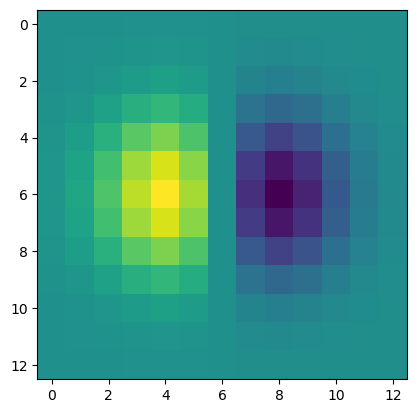

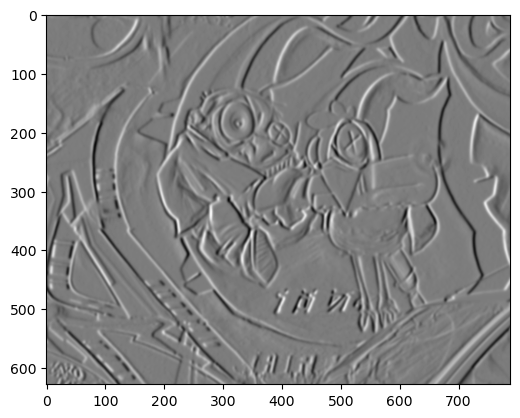

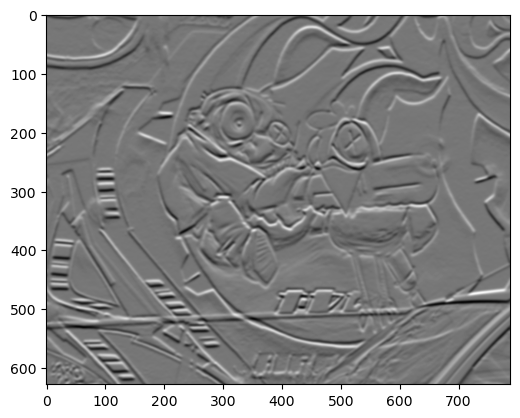

In [28]:
kernel, dx, dy = gaussderiv(graf_gray, sigma=2.0)

plt.imshow(kernel)
plt.show()
plt.imshow(dx, cmap="gray")
plt.show()
plt.imshow(dy, cmap="gray")
plt.show()

# Part 3: Object Identification
In this part you will develop a simple image querying system which accepts a query image as input and then finds a set of similar images in the database. In order to compare images you will implement several distance functions introduced in the lecture and evaluate their performance in combination with different image representations. The data contains model and query images, which will be used to evaluate your implementation. The model and query images correspond to the same set of objects photographed from different viewpoints.
## Loading Images
The following cell loads all model and query images into numpy arrays. Make sure the *model* and *query* folders are in the same folder as this notebook's file.

In [29]:
files_model = []
images_model = []
files_query = []
images_query = []

files = [f"obj{i}__0.png" for i in range(1,101)]

for f in files:
    f = os.path.join(".", "model", f)
    if os.path.isfile(f):
        name = os.path.basename(f).replace("__0.png","")
        files_model += [name]
        images_model += [plt.imread(f)]
        file_query = f"{name}__40.png"
        files_query += [file_query]
        images_query += [plt.imread(os.path.join(".", "query", file_query))]

# stack and convert to grayscale
images_model = np.stack(images_model)
images_model_gray = 0.2989 * images_model[:,:,:,0] + \
                    0.5870 * images_model[:,:,:,1] + \
                    0.1140 * images_model[:,:,:,2]
images_query = np.stack(images_query)
images_query_gray = 0.2989 * images_query[:,:,:,0] + \
                    0.5870 * images_query[:,:,:,1] + \
                    0.1140 * images_query[:,:,:,2]

files_model = np.array(files_model)
files_query = np.array(files_query)

print(images_model.shape, images_model_gray.shape)

(89, 128, 128, 3) (89, 128, 128)


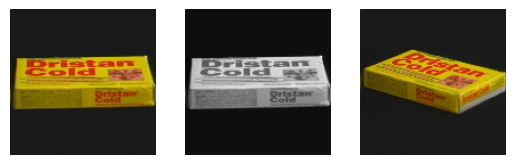

In [30]:
f, ax = plt.subplots(1,3)
ax[0].imshow(images_model[0])
ax[1].imshow(images_model_gray[0], cmap="gray")
ax[2].imshow(images_query[0])
ax[0].axis("off")
ax[1].axis("off")
ax[2].axis("off")
plt.show()

## a) Image Representations, Histogram Distances

### Intensity Histogram

Implement function `normalized_hist`, which takes a gray-value image as input and returns the normalized histogram of pixel intensities. Compare results of your implementation with numpy’s `np.histogram` function to check if your implementation works as intended.

<font color='red'>**TODO:**</font> Complete the next cell to compute a normalized histogram of pixel intensities. Do **not** use existing implementations, e.g. `numpy.histogram`, to do so. [Read up about histograms if necessary](https://en.wikipedia.org/wiki/Histogram).

In [31]:
def normalized_hist(image, nbins=10):
    """
    Compute a normalized intensity histogram for a grayscale image.
    - image: 2D array with values assumed in [0,1]
    - nbins: number of bins
    Returns:
      h: length-nbins array summing to 1
    """
    # Flatten pixels
    pixels = image.ravel()

    # Map pixel values in [0,1] -> bin indices 0..nbins-1
    # Using floor(p * nbins) puts values in [0,1) into bins 0..nbins-1.
    # Values exactly equal to 1.0 would map to nbins, so we clamp those to nbins-1.
    inds = np.floor(pixels * nbins).astype(int)
    inds[inds == nbins] = nbins - 1  # handle pixels == 1.0

    # Count occurrences per bin
    h = np.zeros(nbins, dtype=float)
    for b in range(nbins):
        h[b] = np.sum(inds == b)

    # Normalize to sum = 1 (avoid division by zero)
    total = h.sum()
    if total > 0:
        h = h / total

    return h

Compare your result with numpy's implementation.

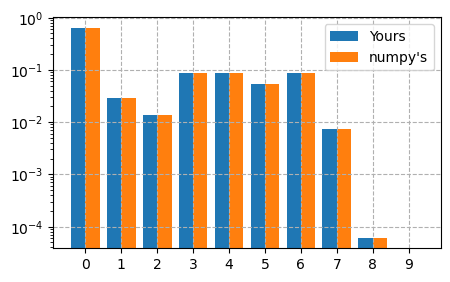

In [32]:
nbins = 10
image_id = 0

h1 = normalized_hist(images_model_gray[image_id], nbins=nbins)
h2, _ = np.histogram(images_model_gray[image_id], bins=np.linspace(0,1,nbins+1))
h2 = h2 / h2.sum()

f = plt.figure(figsize=(5,3))
plt.bar(np.arange(nbins)-0.2, h1, width=0.4)
plt.bar(np.arange(nbins)+0.2, h2, width=0.4)
plt.yscale("log")
plt.xticks(range(nbins))
plt.grid(linestyle="--")
plt.legend(["Yours", "numpy's"])
plt.show()

### RGB Histogram
<font color='red'>**TODO:**</font> Implement the 3-dimensional, normalized RGB-histogram by completing function `rgb_hist`. Go back to the lecture slides for reference.

In [33]:
def rgb_hist(image, nbins=10):
    """
    Compute a normalized 3D RGB histogram for an image.
    - image: HxWx3 array with channel values assumed in [0,1] (if >1, we scale by 255)
    - nbins: number of bins per channel
    Returns:
      h: (nbins, nbins, nbins) array summing to 1
    """
    h = np.zeros((nbins,nbins,nbins))
    # ... continue here

    img = image.astype(float).copy()
    # if image likely in [0,255], scale to [0,1]
    if img.max() > 1.0:
        img = img / 255.0

    # flatten channels
    r = img[:, :, 0].ravel()
    g = img[:, :, 1].ravel()
    b = img[:, :, 2].ravel()

    # compute bin indices in 0..nbins-1
    ri = np.floor(r * nbins).astype(int)
    gi = np.floor(g * nbins).astype(int)
    bi = np.floor(b * nbins).astype(int)

    # clamp values exactly equal to 1.0 (which would map to nbins)
    ri[ri == nbins] = nbins - 1
    gi[gi == nbins] = nbins - 1
    bi[bi == nbins] = nbins - 1

    # accumulate counts into 3D histogram
    np.add.at(h, (ri, gi, bi), 1)

    # normalize to sum = 1
    total = h.sum()
    if total > 0:
        h /= total
        
    return h

Plot your result.

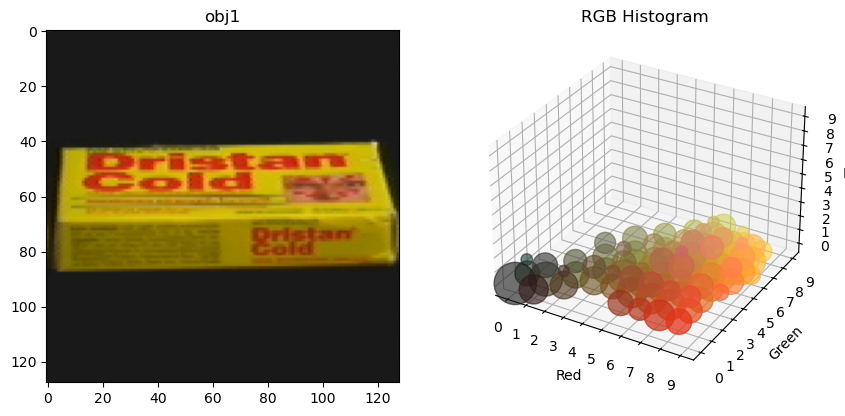

In [34]:
nbins = 10
image_id = 0

h1 = rgb_hist(images_model[image_id], nbins=nbins)

# lets scale and convert our histogram numbers to log-scale to improve visibility
with np.errstate(divide='ignore'):
    h1 = h1 / min(h1[h1!=0])
    h1 = np.nan_to_num(np.log(h1), neginf=0)*100

idx = np.indices((nbins,nbins,nbins)).reshape(3,-1)

f = plt.figure(figsize=(10,6))

ax = f.add_subplot(1,2,1)
ax.imshow(images_model[image_id])
ax.set_title(files_model[image_id])

ax = f.add_subplot(1,2,2, projection="3d")
ax.scatter3D(
    idx[0], idx[1], idx[2],
    c = [( (idx[0,i]+1)/nbins, (idx[1,i]+1)/nbins, (idx[2,i]+1)/nbins ) for i in range(nbins**3)],
    s = [h1[idx[0,i],idx[1,i],idx[2,i]] for i in range(nbins**3)]
)
ax.set_xticks(range(nbins))
ax.set_yticks(range(nbins))
ax.set_zticks(range(nbins))
ax.set_title("RGB Histogram")
ax.set_xlabel("Red")
ax.set_ylabel("Green")
ax.set_zlabel("Blue")
plt.show()

### RG Histogram
<font color='red'>**TODO:**</font> Complete function `rg_hist` to compute a normalized 2-dimensional chromatic representation RG-histogram (see lecture slides).

In [35]:
def rg_hist(image, nbins=10):
    """
    Compute normalized 2D RG-chromaticity histogram.
    image: HxWx3 array with channel values in [0,1] (or [0,255])
    nbins: number of bins per axis for r and g
    Returns: h of shape (nbins, nbins) summing to 1
    """
    h = np.zeros((nbins,nbins))
    # ... continue here

    img = image.astype(float).copy()
    # If image in 0..255, scale to 0..1
    if img.max() > 1.0:
        img = img / 255.0

    # Flatten channels
    R = img[:, :, 0].ravel()
    G = img[:, :, 1].ravel()
    B = img[:, :, 2].ravel()

    S = R + G + B
    # mask out black pixels where sum == 0
    valid = S > 0
    if not np.any(valid):
        return h  # all zeros

    r = R[valid] / S[valid]
    g = G[valid] / S[valid]

    # Map r,g in [0,1] to bin indices 0..nbins-1
    ri = np.floor(r * nbins).astype(int)
    gi = np.floor(g * nbins).astype(int)

    # Clamp values exactly equal to 1.0 into last bin
    ri[ri == nbins] = nbins - 1
    gi[gi == nbins] = nbins - 1

    # Accumulate counts
    np.add.at(h, (ri, gi), 1)

    # Normalize
    total = h.sum()
    if total > 0:
        h /= total

    return h

Plot your result.

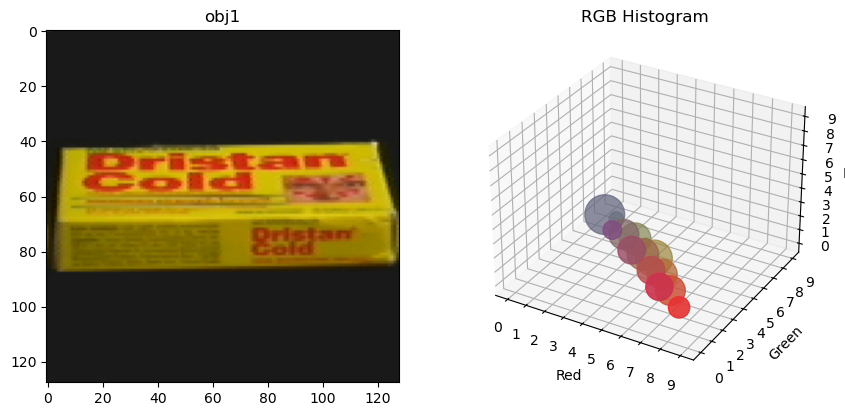

In [36]:
nbins = 10
image_id = 0
h1 = rg_hist(images_model[image_id], nbins=nbins)

# lets scale and convert our histogram numbers to log-scale to improve visibility
with np.errstate(divide='ignore'):
    h1 = h1 / min(h1[h1!=0])
    h1 = np.nan_to_num(np.log(h1), neginf=0)*100

idx = np.array([(r,g,b) for r,g,b in np.indices((nbins,nbins,nbins)).reshape(3,-1).T if r+g+b == nbins]).T

f = plt.figure(figsize=(10,6))

ax = f.add_subplot(1,2,1)
ax.imshow(images_model[image_id])
ax.set_title(files_model[image_id])

ax = f.add_subplot(1,2,2, projection="3d")
ax.scatter3D(
    idx[0], idx[1], idx[2],
    c = [( (idx[0,i]+1)/nbins, (idx[1,i]+1)/nbins, (idx[2,i]+1)/nbins ) for i in range(idx.shape[1])],
    s = [h1[idx[0,i],idx[1,i]] for i in range(idx.shape[1])]
)
ax.set_xticks(range(nbins))
ax.set_yticks(range(nbins))
ax.set_zticks(range(nbins))
ax.set_title("RGB Histogram")
ax.set_xlabel("Red")
ax.set_ylabel("Green")
ax.set_zlabel("Blue")
plt.show()

### dxdy Histogram
<font color='red'>**TODO:**</font> The dxdy histogram computes the 2D histogram of partial derivatives in x and y directions. Implement this histogram by completing function `dxdy_hist`. Hint: Scale the values to [0,1] before computing the histogram.

In [37]:
def dxdy_hist(image, nbins=10):
    """
    Compute a normalized 2D histogram of image partial derivatives (dx, dy).
    - image: 2D grayscale image (values in [0,1] or [0,255])
    - nbins: number of bins per axis (dx, dy)
    Returns:
      h: (nbins, nbins) histogram normalized to sum=1
    """
    h = np.zeros((nbins, nbins), dtype=float)

    _, dx, dy = gaussderiv(image, sigma=1, verbose=False)
    # ... continue here

    # flatten
    dx = dx.ravel()
    dy = dy.ravel()

    # handle constant images or zero-range derivatives safely
    dx_min, dx_max = dx.min(), dx.max()
    dy_min, dy_max = dy.min(), dy.max()

    if dx_max > dx_min:
        dx_scaled = (dx - dx_min) / (dx_max - dx_min)
    else:
        dx_scaled = np.zeros_like(dx)

    if dy_max > dy_min:
        dy_scaled = (dy - dy_min) / (dy_max - dy_min)
    else:
        dy_scaled = np.zeros_like(dy)

    # Map to bin indices 0..nbins-1
    ri = np.floor(dx_scaled * nbins).astype(int)
    gi = np.floor(dy_scaled * nbins).astype(int)

    # Clamp any values equal to nbins (from values == 1.0) to last bin
    ri[ri == nbins] = nbins - 1
    gi[gi == nbins] = nbins - 1

    # Accumulate
    np.add.at(h, (ri, gi), 1)

    # Normalize to sum = 1
    total = h.sum()
    if total > 0:
        h /= total

    return h

Plot your result.

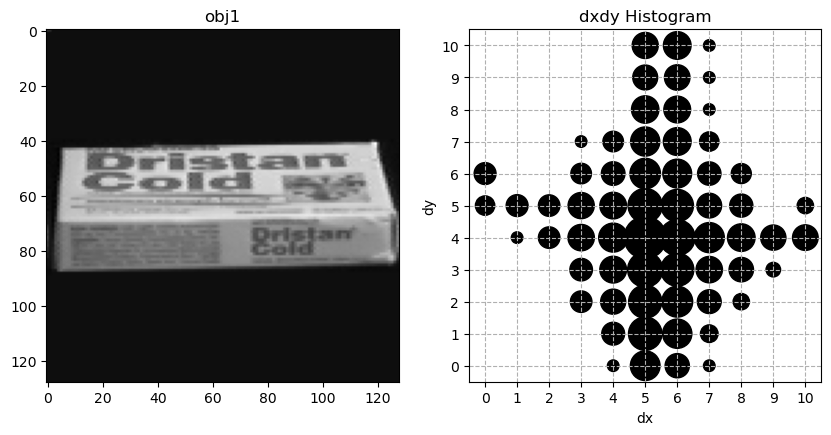

In [38]:
nbins = 11
image_id = 0
h1 = dxdy_hist(images_model_gray[image_id], nbins=nbins)

# lets scale and convert our histogram numbers to log-scale to improve visibility
with np.errstate(divide='ignore'):
    h1 = h1 / min(h1[h1!=0])
    h1 = np.nan_to_num(np.log(h1), neginf=0)*100

idx = np.indices((nbins,nbins)).reshape(2,-1)

f = plt.figure(figsize=(10,6))

ax = f.add_subplot(1,2,1)
ax.imshow(images_model_gray[image_id], cmap="gray")
ax.set_title(files_model[image_id])

ax = f.add_subplot(1,2,2)
ax.scatter(
    idx[0], idx[1],
    c = "black",
    s = [h1[idx[0,i],idx[1,i]] for i in range(idx.shape[1])]
)
ax.set_xticks(range(nbins))
ax.set_yticks(range(nbins))
ax.set_title("dxdy Histogram")
ax.set_xlabel("dx")
ax.set_ylabel("dy")
ax.set_aspect("equal")
ax.grid(linestyle="--")
plt.show()

## b) Histogram Comparison Measures
Implement the histogram distance functions discussed during the lecture by filling the missing code in functions `dist_l2`, `dist_intersect`, and `dist_chi2`.
### Euclidean Distance
<font color='red'>**TODO:**</font> Implement the euclidean distance function to compare two histograms *x* and *y*.

In [39]:
def dist_l2(x,y):
    d = np.sum((x - y) ** 2) # ... continue here
    return d

Test your implementation:

In [40]:
a = np.array([1,2,3,4]) / 10
b = np.array([1,2,4,7]) / 15
dist_l2(a,b) == 0.01111111111111111

True

### Intersection
<font color='red'>**TODO:**</font> Implement the intersection distance function to compare two histograms *x* and *y*.

In [41]:
def dist_intersect(x,y):
    # compute intersection distance between x and y
    # return 1 - intersection, so that smaller values also correspond to more similar histograms
    intersection = np.sum(np.minimum(x, y)) # continue here ...
    return 1-intersection

Test your implementation:

In [42]:
a = np.array([1,2,3,4]) / 10
b = np.array([1,2,4,7]) / 15
dist_intersect(a,b) == 0.1333333333333333

True

### Chi-Square
<font color='red'>**TODO:**</font> Implement the chi-square distance function to compare two histograms *x* and *y*. Note: Add a small value (1E-6) to the denominator to avoid division by zero.

In [45]:
def dist_chi2(x,y):
    # compute chi2 distance between x and y
    # add small value to denominator to not divide by zero
    eps = 1e-6
    d = np.sum(((x - y) ** 2) / (x + y + eps))
    return d

Test your implementation:

In [46]:
a = np.array([1,2,3,4]) / 10
b = np.array([1,2,4,7]) / 15
dist_chi2(a,b) == 0.027088900064936177

True

## c) Object Identification
Having implemented different distance functions and image histograms, we can now test how suitable they are for retrieving images in a query-by-example scenario. Function `find_best_match` takes a list of model images and a list of query images and for each query image returns the index of closest model image according to the given histogram function, distance function, and number of bins. Additionally to the indices of the best matching images, the function returns a matrix which contains distances between all pairs of model and query images.

In [47]:
def find_best_match(model_ids, query_ids, f_hist, f_dist, bins):
    distances = np.zeros((len(query_ids), len(model_ids)))
    
    m_histograms = []
    for idx in model_ids:
        img = images_model[idx] if f_hist in [rgb_hist, rg_hist] else images_model_gray[idx]
        m_histograms += [f_hist(img, bins)]
    
    q_histograms = []
    for idx in query_ids:
        img = images_query[idx] if f_hist in [rgb_hist, rg_hist] else images_query_gray[idx]
        q_histograms += [f_hist(img, bins)]
    
    for q_i, q_hist in enumerate(q_histograms):
        for m_i, m_hist in enumerate(m_histograms):
            distances[q_i, m_i] = f_dist(q_hist, m_hist)
    
    best_match = np.array(range(len(files_query)))[distances.argmin(axis=0)]
    
    return best_match, distances

In [48]:
best_match, distances = find_best_match(
    model_ids = range(len(files_model)),
    query_ids = range(len(files_query)),
    f_hist = rgb_hist,
    f_dist = dist_l2,
    bins = 10
)

### Show Neighbors

Implement a function `show_neighbors` which takes a list of model images and a list of query images and for each query image visualizes several model images which are closest to the query image according to the specified distance metric. Use the function `find_best_match` in your implementation.

<font color='red'>**TODO:**</font> Implement a function that plots the closest model images according to given query images and a combination of histogram function, distance function, and number of bins.

In [49]:
def show_neighbors(model_ids, query_ids, f_hist, f_dist, bins, show_neighbors=5):
    """
    Display, for each query in query_ids, the query image and the closest
    `show_neighbors` model images according to histogram function f_hist
    and distance function f_dist using `bins` bins.
    
    model_ids, query_ids: iterable of indices (these correspond to indices
                          into images_model / images_query when you earlier
                          built the histograms)
    """
    # make lists so we can index them consistently
    model_ids = list(model_ids)
    query_ids = list(query_ids)
    
    # compute distance matrix (rows correspond to query_ids, cols to model_ids)
    _, distances = find_best_match(model_ids, query_ids, f_hist, f_dist, bins)
    
    # For each query (row) show query + top neighbors
    for q_pos, q_idx in enumerate(query_ids):
        dists = distances[q_pos]                # distances to all models in same order as model_ids
        sorted_idx = np.argsort(dists)          # indices into model_ids sorted by increasing distance
        top_k_idx = sorted_idx[:show_neighbors] # top-k model positions (positions in model_ids)
        
        # prepare plotting: one column for query + one for each neighbor
        cols = 1 + show_neighbors
        fig, axes = plt.subplots(1, cols, figsize=(3*cols, 3))
        
        # choose correct image arrays depending on histogram function
        use_color = (f_hist in [rgb_hist, rg_hist])
        
        # Plot query image in first column
        if use_color:
            axes[0].imshow(images_query[q_idx])
        else:
            axes[0].imshow(images_query_gray[q_idx], cmap="gray")
        axes[0].set_title(f"Query\n{files_query[q_idx]}")
        axes[0].axis("off")
        
        # Plot neighbors
        for i, m_pos in enumerate(top_k_idx, start=1):
            m_idx = model_ids[m_pos]  # actual model index in images_model arrays
            if use_color:
                img = images_model[m_idx]
            else:
                img = images_model_gray[m_idx]
            axes[i].imshow(img, cmap=None if use_color else "gray")
            axes[i].set_title(f"Rank {i}\n{files_model[m_idx]}\nDist={dists[m_pos]:.4f}")
            axes[i].axis("off")
        
        plt.suptitle(f"Query {q_pos} -> top {show_neighbors} neighbors (hist={f_hist.__name__}, dist={f_dist.__name__}, bins={bins})")
        plt.show()


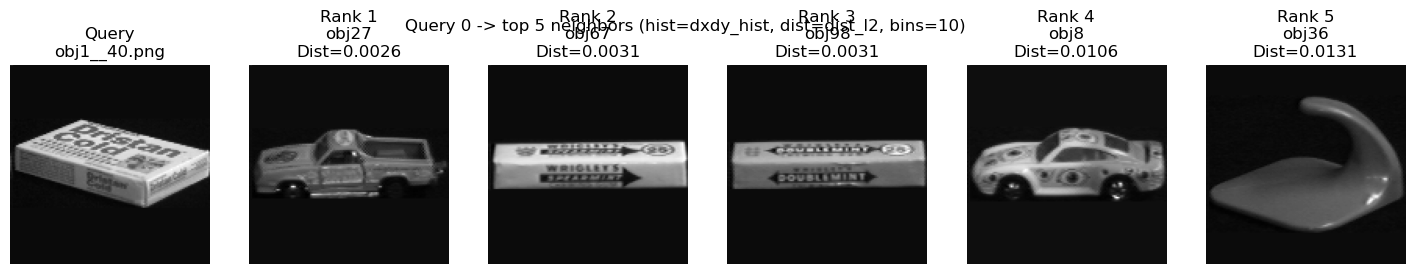

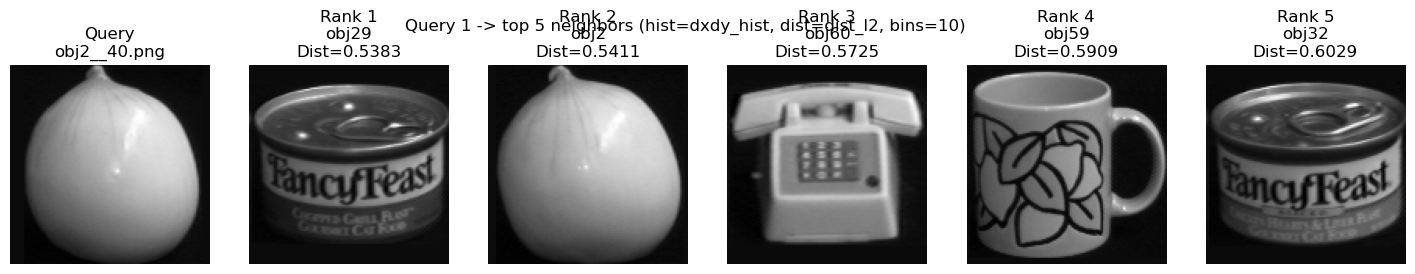

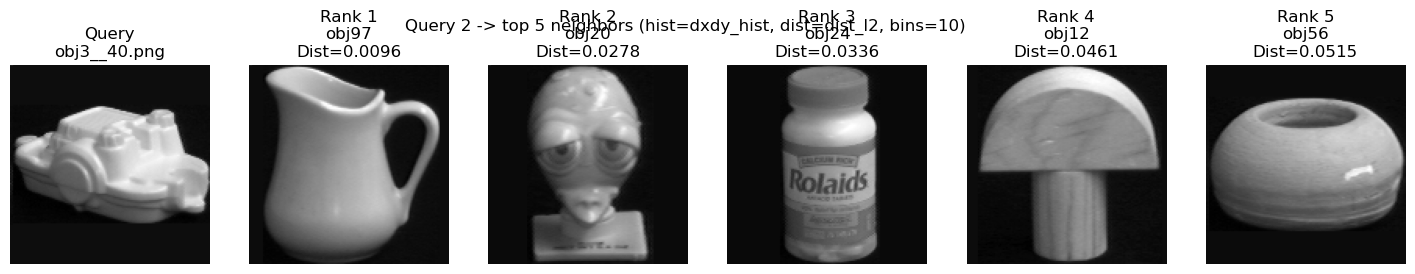

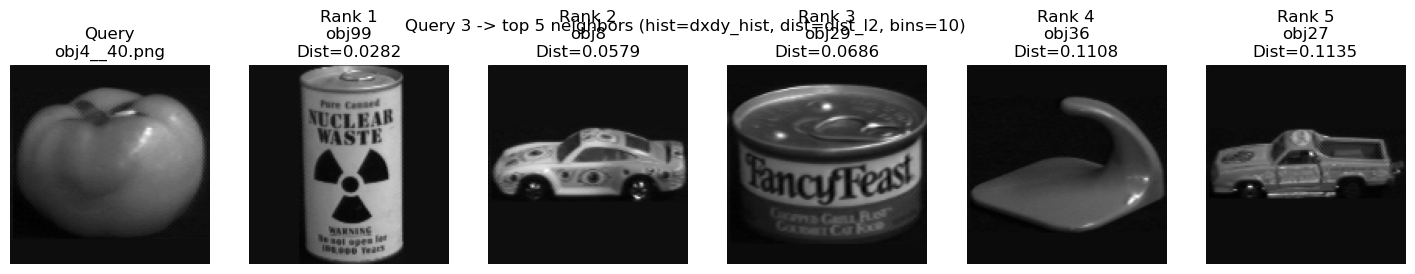

In [50]:
show_neighbors(
    model_ids = range(len(files_model)),
    query_ids = range(4),
    f_hist = dxdy_hist,
    f_dist = dist_l2,
    bins = 10
)

### Recognition Rate

Use function `find_best_match` to compute recognition rates for different combinations of distance and histogram functions. The recognition rate is given by a ratio between number of correct matches and total number of query images. A match is correct if the best match of a given query image is the corresponding model image, hence, the same object. Example: Given 10 query images and 6 correct matches, the recognition rate is 6/10 = 0.6.

<font color='red'>**TODO:**</font> Compute recognition rates of different combinations of histogram functions, distance functions, and number of bins. Try to find a combination that works best. Why do you think the combination you found works particularly well? Discuss your results.

In [ ]:
hist_types = [normalized_hist, rgb_hist, rg_hist, dxdy_hist]
dist_types = [dist_l2, dist_intersect, dist_chi2]
bins_list = # your choice

# continue here ...